In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_curve,auc,classification_report,precision_score,recall_score,confusion_matrix,classification_report


import xgboost as xgb
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")

## Preparing data

In [66]:
df = pd.read_csv('../data.csv')
df.shape

(14430, 32)

In [67]:
df.columns

Index(['LITHOLOGY', 'LULC11_12', 'LULC15_16', 'PANCHAYATH_CODE',
       'PANCHAYATH_NAME', 'HAND', 'TPI', 'ASPEC', 'DRAIN_DEN', 'NDBI', 'NDVI',
       'SPI', 'TRI', 'TWI', 'ELEVATION', 'PLANCU', 'PROFCU', 'RRELIEF',
       'GW_IDW', 'LINEAMENT_DEN', 'ROAD_DEN', 'SLOPE', 'D_RAINFALL', 'SOIL_T',
       'SOIL_DEPTH', 'SOIL_TEXTURE', 'VILLAGE_BLK', 'X', 'Y', 'Slide',
       'Slide_prob', 'Zone'],
      dtype='object')

In [68]:
#rename columns
df.rename(columns={'Slide_prob':'Static Predicted Probability',
'Zone':'Static predicted zone','Slide':'Original Slide label'},inplace=True)

df = df[[ 'X', 'Y','Original Slide label','Static Predicted Probability','Static predicted zone',
       'LITHOLOGY', 'LULC11_12', 'LULC15_16', 'PANCHAYATH_CODE',
       'PANCHAYATH_NAME', 'HAND', 'TPI', 'ASPEC', 'DRAIN_DEN', 'NDBI', 'NDVI',
       'SPI', 'TRI', 'TWI', 'ELEVATION', 'PLANCU', 'PROFCU', 'RRELIEF',
       'GW_IDW', 'LINEAMENT_DEN', 'ROAD_DEN', 'SLOPE', 'D_RAINFALL', 'SOIL_T',
       'SOIL_DEPTH', 'SOIL_TEXTURE', 'VILLAGE_BLK']]
df.shape



(14430, 32)

In [69]:
# mapping
lithology_types = {1:'Hornblende Gneiss',2:'Charnakite',3:'Granite',4:'Garnet-biotite Gneiss',5:'Pink Granite Gneiss'}
lulc11_12 = {1: 'Agriculture Plantation',2: 'Barren Rocky',3: 'Built-Up - Compact',4: 'Built-Up - Sparse',
              5: 'Crop - Kharif',6: 'Crop - Rabi',7: 'Cropped in 2 Seasons',8: 'Deciduous Forest - Closed',
              9: 'Deciduous Forest - Open',10: 'Evergreen / Semi Evergreen Forest - Closed',
              11: 'Evergreen / Semi Evergreen Forest - Open',12: 'Fallow Land',13: 'Forest Plantation',
              14: 'Grassland - Temperate / Sub Tropical',15: 'Industrial Area',16: 'Lake - Permanent',
              17: 'Lake - Seasonal',18: 'Mining - Abandoned',19: 'Mining - Active',20: 'Reservoir - Permanent',
              21: 'Reservoir - Seasonal',22: 'River - Non Perennial',23: 'River - Perennial',24: 'Rural',25: 'Scrub Forest',
              26: 'Scrubland - Closed',27: 'Scrubland - Open',28: 'Tree Clad Area - Closed',
              29: 'Tree Clad Area - Open'}

lulc15_16 = {1: 'Agriculture Plantation',2: 'Barren Rocky',3: 'Built-Up - Compact',4: 'Built-Up - Sparse',5: 'Crop - Kharif',
            6: 'Crop - Rabi',7: 'Cropped in 2 Seasons',8: 'Deciduous Forest - Closed',9: 'Deciduous Forest - Open',10: 'Evergreen / Semi Evergreen Forest - Closed',
            11: 'Evergreen / Semi Evergreen Forest - Open',12: 'Fallow Land',13: 'Forest Plantation',14: 'Grassland - Temperate / Sub Tropical',
            15: 'Industrial Area',16: 'Lake - Permanent',17: 'Lake - Seasonal',18: 'Mining - Abandoned',19: 'Mining - Active',
            20: 'Quarry Area',21: 'Reservoir - Permanent',22: 'Reservoir - Seasonal',23: 'River - Non Perennial',
            24: 'River - Perennial',25: 'Rural',26: 'Scrub Forest',27: 'Scrubland - Closed',
            28: 'Scrubland - Open',29: 'Tree Clad Area - Closed',30: 'Urban Vegetated / Open Area'}

# slope_types = {1:'Very Gentle',2: 'Gentle', 3: 'Moderate', 4: 'Moderatly Steep', 5: 'Steep', 6: 'Very Steep'}

# aspec_types = {1: 'Flat', 2: 'North', 3 :'Northeast',4 :'East', 5:'Southeast', 6:'South',7:'Southwest',
#                  8:'West',  9:'Northwest', 10 :'North' }

depth_types = {1:'Very deep',2:'Waterbody/Tank',3:'Deep'}

soil_texture_types = {1:'Clay',2:'Loam',3:'Gravelly Clay',4: 'Waterbody/Tank',5:'Gravelly Loam'}

df['LITHOLOGY'] = df['LITHOLOGY'].map(lithology_types)
df['LULC11_12'] = df['LULC11_12'].map(lulc11_12)
df['LULC15_16'] = df['LULC15_16'].map(lulc15_16)
df['SOIL_DEPTH'] = df['SOIL_DEPTH'].map(depth_types)
df['SOIL_TEXTURE'] = df['SOIL_TEXTURE'].map(soil_texture_types)

df.to_csv('db.csv',index=False)


In [70]:
# df = pd.read_csv('db.csv')
# droping rows with count <= 5. ie, removing rows with less frequency values
drop_11_12 = ['River - Non Perennial','Lake - Permanent','Crop - Kharif','Crop - Rabi','Industrial Area'] 
drop_15_16 = ['Mining - Abandoned','Urban Vegetated / Open Area','Industrial Area','Crop - Kharif',
              'Quarry Area','River - Non Perennial']

print(df.shape)
df = df[~df['LULC15_16'].isin(drop_15_16)]
df = df[~df['LULC11_12'].isin(drop_11_12)]
print(df.shape)

(14430, 32)
(14411, 32)


# Load Data

In [71]:
# db_drop_cols = ['X','Y','PANCHAYATH_CODE','VILLAGE_BLK','Slide','Slide_prob','Zone']
df = pd.read_csv('db.csv')
drop_cols = ['X','Y','PANCHAYATH_CODE','VILLAGE_BLK','Original Slide label', 'Static Predicted Probability',
       'Static predicted zone','PANCHAYATH_NAME']

y = df['Original Slide label']
X = df.drop(columns=drop_cols)
X.shape,y.shape


((14430, 24), (14430,))

In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14430 entries, 0 to 14429
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LITHOLOGY      14430 non-null  object
 1   LULC11_12      14430 non-null  object
 2   LULC15_16      14430 non-null  object
 3   HAND           14430 non-null  int64 
 4   TPI            14430 non-null  int64 
 5   ASPEC          14430 non-null  int64 
 6   DRAIN_DEN      14430 non-null  int64 
 7   NDBI           14430 non-null  int64 
 8   NDVI           14430 non-null  int64 
 9   SPI            14430 non-null  int64 
 10  TRI            14430 non-null  int64 
 11  TWI            14430 non-null  int64 
 12  ELEVATION      14430 non-null  int64 
 13  PLANCU         14430 non-null  int64 
 14  PROFCU         14430 non-null  int64 
 15  RRELIEF        14430 non-null  int64 
 16  GW_IDW         14430 non-null  int64 
 17  LINEAMENT_DEN  14430 non-null  int64 
 18  ROAD_DEN       14430 non-n

### Train test split

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

basic_cols = X_train.columns.tolist()

(11544, 24)
(2886, 24)
(11544,)
(2886,)


In [45]:
#CHECKING UNSIQUES

### Checking train and test has variation in categorical values

def checker(col):
    print(col)
    to = X[col].value_counts().index
    tr = X_train[col].value_counts().index
    te = X_test[col].value_counts().index
    out = [i for i in te if i not in tr]
    out_len = len(out)
    print(f'{out_len} new categories found in test: {out}')
    if len(to) != len(tr):
        print('Missing categories found')
    print('_'*20)
    
for col in X_train.columns:
    checker(col)

LITHOLOGY
0 new categories found in test: []
____________________
LULC11_12
0 new categories found in test: []
____________________
LULC15_16
1 new categories found in test: ['Urban Vegetated / Open Area']
Missing categories found
____________________
HAND
0 new categories found in test: []
____________________
TPI
0 new categories found in test: []
____________________
ASPEC
0 new categories found in test: []
____________________
DRAIN_DEN
0 new categories found in test: []
____________________
NDBI
0 new categories found in test: []
____________________
NDVI
0 new categories found in test: []
____________________
SPI
0 new categories found in test: []
____________________
TRI
0 new categories found in test: []
____________________
TWI
0 new categories found in test: []
____________________
ELEVATION
0 new categories found in test: []
____________________
PLANCU
0 new categories found in test: []
____________________
PROFCU
0 new categories found in test: []
____________________
RRELI

In [46]:
obj_cols = ['LITHOLOGY','LULC11_12','LULC15_16','SOIL_DEPTH','SOIL','SOIL_T','SOIL_TEXTURE']
num_cols = ['HAND', 'TPI', 'ASPEC',
       'DRAIN_DEN', 'NDBI', 'NDVI', 'SPI', 'TRI', 'TWI', 'ELEVATION', 'PLANCU',
       'PROFCU', 'RRELIEF', 'GW_IDW', 'LINEAMENT_DEN', 'ROAD_DEN', 'SLOPE',
       'D_RAINFALL']

In [47]:
# one hot encoder

known_lithology = ['Charnakite', 'Hornblende Gneiss', 'Pink Granite Gneiss',
       'Garnet-biotite Gneiss', 'Granite']


known_lulc11_12 = ['Evergreen / Semi Evergreen Forest - Closed', 'Agriculture Plantation',
       'Scrub Forest', 'Forest Plantation',
       'Grassland - Temperate / Sub Tropical', 'Barren Rocky',
       'Deciduous Forest - Open', 'Rural', 'Scrubland - Closed',
       'Deciduous Forest - Closed', 'Reservoir - Permanent',
       'Evergreen / Semi Evergreen Forest - Open', 'Cropped in 2 Seasons',
       'Scrubland - Open', 'River - Perennial', 'Fallow Land',
       'Reservoir - Seasonal']

known_lulc15_16 = ['Evergreen / Semi Evergreen Forest - Closed', 'Agriculture Plantation',
       'Forest Plantation', 'Barren Rocky', 'Deciduous Forest - Open', 'Rural',
       'Deciduous Forest - Closed', 'Cropped in 2 Seasons',
       'Grassland - Temperate / Sub Tropical',
       'Evergreen / Semi Evergreen Forest - Open', 'Reservoir - Permanent',
       'Scrubland - Closed', 'Scrubland - Open', 'Scrub Forest',
       'River - Perennial', 'Fallow Land', 'Reservoir - Seasonal',
       'Crop - Rabi']

known_soil_depth = ['Very deep', 'Waterbody/Tank', 'Deep']
known_soil_texture = ['Clay', 'Waterbody/Tank', 'Gravelly Loam', 'Loam', 'Gravelly Clay']
known_soil_types = [i for i in range(1,12)]



train_litho = pd.Categorical(X_train['LITHOLOGY'].values, categories = known_lithology)
train_litho = pd.get_dummies(train_litho)
test_litho = pd.Categorical(X_test['LITHOLOGY'].values, categories = known_lithology)
test_litho = pd.get_dummies(test_litho)


train_lulc11_12 = pd.Categorical(X_train['LULC11_12'].values, categories = known_lulc11_12)
train_lulc11_12 = pd.get_dummies(train_lulc11_12)
test_lulc11_12 = pd.Categorical(X_test['LULC11_12'].values, categories = known_lulc11_12)
test_lulc11_12 = pd.get_dummies(test_lulc11_12)
train_lulc11_12.columns = [f'{i}_LULC11_12' for i in train_lulc11_12.columns]
test_lulc11_12.columns = [f'{i}_LULC11_12' for i in test_lulc11_12.columns]

train_lulc15_16 = pd.Categorical(X_train['LULC15_16'].values, categories = known_lulc15_16)
train_lulc15_16 = pd.get_dummies(train_lulc15_16)
test_lulc15_16 = pd.Categorical(X_test['LULC15_16'].values, categories = known_lulc15_16)
test_lulc15_16 = pd.get_dummies(test_lulc15_16)
train_lulc15_16.columns = [f'{i}_LULC15_16' for i in train_lulc15_16.columns]
test_lulc15_16.columns = [f'{i}_LULC15_16' for i in test_lulc15_16.columns]

train_soil_depth = pd.Categorical(X_train['SOIL_DEPTH'].values, categories = known_soil_depth)
train_soil_depth = pd.get_dummies(train_soil_depth)
test_soil_depth = pd.Categorical(X_test['SOIL_DEPTH'].values, categories = known_soil_depth)
test_soil_depth = pd.get_dummies(test_soil_depth)
train_soil_depth.columns = [f'{i}_SOIL_DEPTH' for i in train_soil_depth.columns]
test_soil_depth.columns = [f'{i}_SOIL_DEPTH' for i in test_soil_depth.columns]

train_soil_texture = pd.Categorical(X_train['SOIL_TEXTURE'].values, categories = known_soil_texture)
train_soil_texture = pd.get_dummies(train_soil_texture)
test_soil_texture = pd.Categorical(X_test['SOIL_TEXTURE'].values, categories = known_soil_texture)
test_soil_texture = pd.get_dummies(test_soil_texture)
train_soil_texture.columns = [f'{i}_SOIL_TEXTURE' for i in train_soil_texture.columns]
test_soil_texture.columns = [f'{i}_SOIL_TEXTURE' for i in test_soil_texture.columns]


train_soil_types = pd.Categorical(X_train['SOIL_T'].values, categories = known_soil_types)
train_soil_types = pd.get_dummies(train_soil_types)
train_soil_types.columns = [f'soil_type_K{i}' for i in range(1,12)]
test_soil_types = pd.Categorical(X_test['SOIL_T'].values, categories = known_soil_types)
test_soil_types = pd.get_dummies(test_soil_types)
test_soil_types.columns = [f'soil_type_K{i}' for i in range(1,12)]


In [48]:
train_cat = pd.concat([train_litho,train_lulc11_12,train_lulc15_16,train_soil_depth,train_soil_texture,train_soil_types],axis=1)
test_cat =  pd.concat([test_litho,test_lulc11_12,test_lulc15_16,test_soil_depth,test_soil_texture,test_soil_types],axis=1)

train_cat.shape,test_cat.shape

((11544, 59), (2886, 59))

In [49]:
X_train = pd.concat([X_train[num_cols],train_cat],axis=1)
X_test = pd.concat([X_test[num_cols],test_cat],axis=1)

print(X_train.shape,X_test.shape)

(11544, 77) (2886, 77)


In [11]:
# count = {}
# for i in X_train.columns:
#     if i not in count.keys():
#         count[i] = 1
        
#     else:
#         count[i] += 1

In [50]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(y_train,y_train_pred,y_test,y_test_pred):
    cm_train = confusion_matrix(y_train,y_train_pred)
    cm_test =  confusion_matrix(y_test,y_test_pred)
    class_label = ["no slide","slide"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

## Model

In [140]:
params = {'booster':['gbtree','gblinear'],
              'learning_rate': [0.1], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}

clf = xgb.XGBClassifier()
rcv = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=3,scoring="roc_auc")
rcv.fit(X_train,y_train)
print("Model with best parameters :\n",rcv.best_params_)
rcv.best_estimator_

[12:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:05:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:05:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=20, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, reg_lambda=3, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
def cross_model(model,X_train,y_train):
    """
    Do stratified k fold validation and will return cv score
    """
    
    cv_auc_sum = 0
 
    skf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
    for train_index, cv_index in skf.split(X_train, y_train):
        x_train, x_cv = X_train.loc[train_index], X_train.loc[cv_index]
        y_tr, y_cv = y_train[train_index], y_train[cv_index]

        model.fit(x_train,y_tr)
    
        train_fpr, train_tpr, thresholds = roc_curve(y_tr, model.predict_proba(x_train)[:,1])
        cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv)[:,1])
        
        
        cv_auc_sum += auc(cv_fpr, cv_tpr)
    
    
    cv_auc =  cv_auc_sum/3
    return cv_auc

[12:27:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:27:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:27:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:27:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

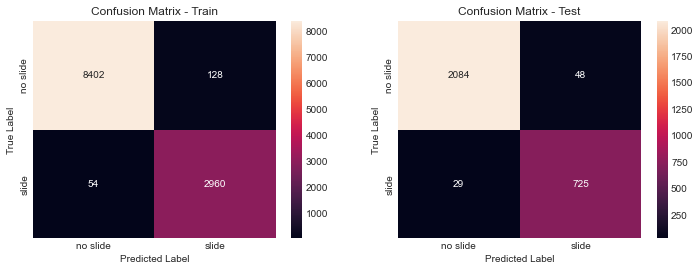

In [52]:
xgb_model = xgb.XGBClassifier(reg_lambda=3,
                              reg_alpha= 1,
                              n_estimators= 400,
                              min_child_weight= 25,
                              max_depth= 10,
                              learning_rate= 0.1,
                              gamma= 1,
                              colsample_bytree= 1,
                              booster= 'gbtree')



model = xgb_model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# do cross validation to get cv auc
cv_auc = cross_model(xgb_model,X_train,y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])


#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under cv roc {}'.format(cv_auc))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


print(f'Train classification report: ')
print(classification_report(y_train,y_train_pred))

print(f'Test classification report: ')
print(classification_report(y_test,y_test_pred))


plot_confusion_matrixes(y_train,y_train_pred,y_test,y_test_pred)


Area under train roc 0.9957316423318769
Area under test roc 0.9939360309742661


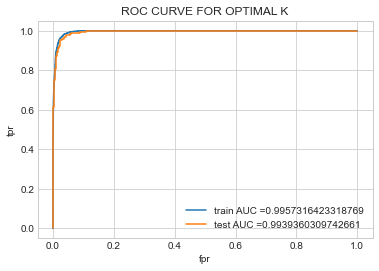

In [62]:

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])


#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))




plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

In [39]:
# #save model
# import pickle
# file_name = "xgb_model.pkl"

# # save
# pickle.dump(model, open(file_name, "wb"))

# # load
# model = pickle.load(open(file_name, "rb"))

In [55]:
#using xgboosit api

model.save_model("xgb_model.json")

#load
model_xgb = xgb.XGBClassifier(reg_lambda=3,
                              reg_alpha= 1,
                              n_estimators= 400,
                              min_child_weight= 25,
                              max_depth= 10,
                              learning_rate= 0.1,
                              gamma= 1,
                              colsample_bytree= 1,
                              booster= 'gbtree')

model_xgb.load_model("xgb_model.json")

In [61]:
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=25, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, reg_lambda=3, scale_pos_weight=1, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)

# Inference

In [76]:
import pandas as pd


def fetch_panchayath(df,panchayath='Marayoor'):
    """
    fetch panchayath dataframe
    """
    df = df[df['PANCHAYATH_NAME'] == panchayath]
    if df.shape[0] >= 100:
        df = df.head(100)
    return df

In [83]:
data = {'panchayath_name':'Marayoor','rain_water_level':2,'ground_water_level':1}

panchayath_name = data['panchayath_name']
rain_water_level = data['rain_water_level']
gwd_water_level = data['ground_water_level']
    
DB = pd.read_csv('db.csv')
df = fetch_panchayath(DB,panchayath=panchayath_name)

drop_cols = ['X','Y','PANCHAYATH_CODE','VILLAGE_BLK','Original Slide label', 'Static Predicted Probability',
       'Static predicted zone','PANCHAYATH_NAME']
       
df = df.drop(columns=drop_cols)
print(df.shape)
df.head(3)

(100, 24)


,LITHOLOGY,LULC11_12,LULC15_16,HAND,TPI,ASPEC,DRAIN_DEN,NDBI,NDVI,SPI,...,PROFCU,RRELIEF,GW_IDW,LINEAMENT_DEN,ROAD_DEN,SLOPE,D_RAINFALL,SOIL_T,SOIL_DEPTH,SOIL_TEXTURE
0,Pink Granite Gneiss,Evergreen / Semi Evergreen Forest - Closed,Evergreen / Semi Evergreen Forest - Closed,1,5,3,2,4,4,3,...,5,5,1,2,4,4,5,2,Very deep,Clay
1,Pink Granite Gneiss,Scrub Forest,Grassland - Temperate / Sub Tropical,1,9,4,2,2,5,4,...,2,5,1,2,4,5,5,2,Very deep,Clay
2,Pink Granite Gneiss,Scrub Forest,Evergreen / Semi Evergreen Forest - Closed,4,3,6,2,2,4,5,...,6,5,1,2,3,4,5,2,Very deep,Clay


In [84]:
def process_pipleine(df):
    """
    crate dataframa after one hot encoding
    
    """

    # one hot encoder
    known_lithology = ['Charnakite', 'Hornblende Gneiss', 'Pink Granite Gneiss',
        'Garnet-biotite Gneiss', 'Granite']


    known_lulc11_12 = ['Evergreen / Semi Evergreen Forest - Closed', 'Agriculture Plantation',
        'Scrub Forest', 'Forest Plantation',
        'Grassland - Temperate / Sub Tropical', 'Barren Rocky',
        'Deciduous Forest - Open', 'Rural', 'Scrubland - Closed',
        'Deciduous Forest - Closed', 'Reservoir - Permanent',
        'Evergreen / Semi Evergreen Forest - Open', 'Cropped in 2 Seasons',
        'Scrubland - Open', 'River - Perennial', 'Fallow Land',
        'Reservoir - Seasonal']

    known_lulc15_16 = ['Evergreen / Semi Evergreen Forest - Closed', 'Agriculture Plantation',
        'Forest Plantation', 'Barren Rocky', 'Deciduous Forest - Open', 'Rural',
        'Deciduous Forest - Closed', 'Cropped in 2 Seasons',
        'Grassland - Temperate / Sub Tropical',
        'Evergreen / Semi Evergreen Forest - Open', 'Reservoir - Permanent',
        'Scrubland - Closed', 'Scrubland - Open', 'Scrub Forest',
        'River - Perennial', 'Fallow Land', 'Reservoir - Seasonal',
        'Crop - Rabi']

    known_soil_depth = ['Very deep', 'Waterbody/Tank', 'Deep']
    known_soil_texture = ['Clay', 'Waterbody/Tank', 'Gravelly Loam', 'Loam', 'Gravelly Clay']
    known_soil_types = [i for i in range(1,12)]



    train_litho = pd.Categorical(df['LITHOLOGY'].values, categories = known_lithology)
    train_litho = pd.get_dummies(train_litho)


    train_lulc11_12 = pd.Categorical(df['LULC11_12'].values, categories = known_lulc11_12)
    train_lulc11_12 = pd.get_dummies(train_lulc11_12)
    train_lulc11_12.columns = [f'{i}_LULC11_12' for i in train_lulc11_12.columns]
   

    train_lulc15_16 = pd.Categorical(df['LULC15_16'].values, categories = known_lulc15_16)
    train_lulc15_16 = pd.get_dummies(train_lulc15_16)
    train_lulc15_16.columns = [f'{i}_LULC15_16' for i in train_lulc15_16.columns]


    train_soil_depth = pd.Categorical(df['SOIL_DEPTH'].values, categories = known_soil_depth)
    train_soil_depth = pd.get_dummies(train_soil_depth)
    train_soil_depth.columns = [f'{i}_SOIL_DEPTH' for i in train_soil_depth.columns]
 

    train_soil_texture = pd.Categorical(df['SOIL_TEXTURE'].values, categories = known_soil_texture)
    train_soil_texture = pd.get_dummies(train_soil_texture)
    train_soil_texture.columns = [f'{i}_SOIL_TEXTURE' for i in train_soil_texture.columns]

    train_soil_types = pd.Categorical(df['SOIL_T'].values, categories = known_soil_types)
    train_soil_types = pd.get_dummies(train_soil_types)
    train_soil_types.columns = [f'soil_type_K{i}' for i in range(1,12)]
    
    train_cat = pd.concat([train_litho,train_lulc11_12,train_lulc15_16,train_soil_depth,train_soil_texture,train_soil_types],axis=1)
    
    num_cols = ['HAND', 'TPI', 'ASPEC',
       'DRAIN_DEN', 'NDBI', 'NDVI', 'SPI', 'TRI', 'TWI', 'ELEVATION', 'PLANCU',
       'PROFCU', 'RRELIEF', 'GW_IDW', 'LINEAMENT_DEN', 'ROAD_DEN', 'SLOPE',
       'D_RAINFALL']
    df_ = pd.concat([df[num_cols],train_cat],axis=1)
    return df_


In [82]:
df_ = process_pipleine(df)
print(df_.shape)
df_.head(3)

(100, 77)


,HAND,TPI,ASPEC,DRAIN_DEN,NDBI,NDVI,SPI,TRI,TWI,ELEVATION,...,soil_type_K2,soil_type_K3,soil_type_K4,soil_type_K5,soil_type_K6,soil_type_K7,soil_type_K8,soil_type_K9,soil_type_K10,soil_type_K11
0,1,5,3,2,4,4,3,3,1,9,...,1,0,0,0,0,0,0,0,0,0
1,1,9,4,2,2,5,4,4,1,9,...,1,0,0,0,0,0,0,0,0,0
2,4,3,6,2,2,4,5,2,2,10,...,1,0,0,0,0,0,0,0,0,0


In [60]:
out = model_xgb.predict_proba(df_)[:,1]
df_['predicted_prob'] = out
df_['predicted_prob'].head()

0    0.950505
1    0.988160
2    0.985627
3    0.986395
4    0.930555
Name: predicted_prob, dtype: float32

In [53]:
out_dict = df_.to_dict('list')
out_dict

{'HAND': [1,
  1,
  4,
  1,
  4,
  1,
  3,
  1,
  1,
  3,
  3,
  3,
  1,
  1,
  3,
  1,
  1,
  1,
  4,
  2,
  1,
  5,
  4,
  1,
  3,
  3,
  4,
  4,
  2,
  4,
  1,
  2,
  2,
  2,
  1,
  3,
  3,
  4,
  1,
  1,
  1,
  4,
  1,
  3,
  2,
  3,
  2,
  1,
  4,
  2,
  1,
  5,
  4,
  4,
  2,
  1,
  2,
  1,
  2,
  4,
  4,
  2,
  1,
  2,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  4,
  3,
  3,
  1,
  2,
  2,
  1,
  2,
  3,
  2,
  1,
  1,
  3,
  4,
  1,
  2,
  2,
  1,
  1,
  3,
  1,
  4,
  2,
  3,
  1,
  3,
  3,
  4,
  3],
 'TPI': [5,
  9,
  3,
  4,
  6,
  6,
  6,
  5,
  3,
  3,
  7,
  4,
  5,
  5,
  7,
  7,
  5,
  5,
  7,
  5,
  4,
  6,
  5,
  6,
  6,
  8,
  2,
  4,
  3,
  4,
  4,
  8,
  5,
  6,
  5,
  8,
  5,
  7,
  7,
  3,
  6,
  5,
  6,
  8,
  7,
  6,
  6,
  7,
  5,
  6,
  6,
  6,
  6,
  4,
  5,
  6,
  5,
  2,
  5,
  8,
  5,
  5,
  5,
  8,
  6,
  6,
  6,
  7,
  7,
  7,
  6,
  6,
  6,
  4,
  5,
  4,
  6,
  5,
  2,
  3,
  3,
  6,
  6,
  6,
  7,
  4,
  5,
  4,
  3,
  7,
  6,
  7,
  5,
  6,
  5,
  6,
  6,